In [1]:
import numpy as np
from scipy.stats import norm, chi2, gaussian_kde, t, uniform
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.api import qqplot
from statsmodels.stats.stattools import jarque_bera, omni_normtest
import wooldridge
from numba import njit

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

In [2]:
n = 10000

In [3]:
u = np.zeros(n)
u

array([0., 0., 0., ..., 0., 0., 0.])

In [4]:
u_sd = 0.5

In [5]:
for i in range(n):  # (1)
    
    prob = 0.05  # (2)
    dist_1 = norm.rvs(loc=0, scale=u_sd, size=1)  #(3)
    dist_2 = (chi2.rvs(1, size=1) - 1) / np.sqrt(2)  # (4)
    
    error = prob*(dist_1)+(1-prob)*(dist_2)  # (5)
    u[i] = error  # (6)

In [6]:
u[:10]

array([-0.14845375,  5.16589721, -0.59904972, -0.64099543, -0.60525385,
       -0.72740918, -0.59237322, -0.59261835, -0.55365762, -0.64283992])

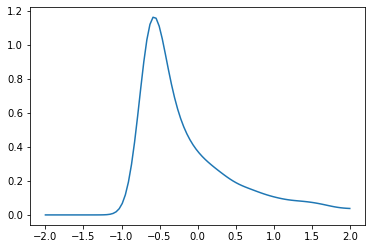

In [7]:
x=np.linspace(-2.0,2.0,100)  # 図を作成するために-2から２までの横軸の値を設定
kde_model=gaussian_kde(u)  # カーネル密度推定を設定
ufunc = kde_model(x)  # カーネル密度推定を使い誤差項の分布を推定
plt.plot(x, ufunc)  # 誤差項の分布をプロット
pass

In [8]:
u.mean()

0.0004372503865539356

In [9]:
b0 = 1  # 定数項
b1 = 0.5  # 説明変数の係数

In [10]:
N = 10000

In [11]:
@njit  # 計算の高速化
def sim_consistency(n):
    
    b1_arr = np.zeros(N)  # b1の推定値を格納するarray

    for i in range(N):  #  forループで N回シミュレーション
        
        x = np.random.normal(loc=4, scale=0.5, size=n)  # 説明変数
        
        # 残差の生成（上で説明したもの）
        u = np.zeros(n)
        
        for j in range(n):
            prob = 0.05  # 正規分布の確率
            dist_1 = np.random.normal(loc=0, scale=u_sd)
            dist_2 = (np.random.chisquare(1) - 1) / np.sqrt(2)
            error = prob*(dist_1)+(1-prob)*(dist_2)
            u[j] = error
            
        y = b0 + b1 * x + u  # yの抽出
        
        var_cov = np.cov(y,x)  # 分散共分散行列
        cov_yx = var_cov[0,1]  # 共分散
        var_y = var_cov[0,0]  # yの分散
        var_x = var_cov[1,1]  # xの分散        
        b1hat = cov_yx / var_x  # スロープ係数       
        b1_arr[i] = b1hat  # スロープ係数を b1_arrに格納

    return b1_arr   # 推定値のリストを返す

In [12]:
data_consistency = {}  # 空の辞書の作成

for i in [30,100,250,500]:
    data_consistency[str(i)] = sim_consistency(i)

In [13]:
data_consistency['30']

array([0.13571839, 0.14905804, 1.27548911, ..., 0.62986967, 0.06663164,
       0.40928078])

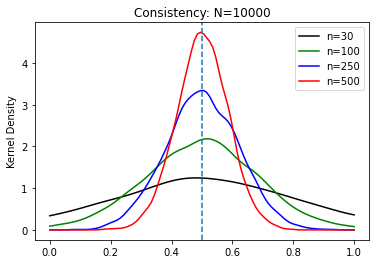

In [14]:
# 図を作成するために横軸の値を設定
xx=np.linspace(0.0,1.0,100)

# n = 30
kde_model_30=gaussian_kde(data_consistency['30'])  # カーネル密度推定を使いOLS推定量の分布を推定
plt.plot(xx, kde_model_30(xx), 'k', label='n=30')  # OLS推定量の分布プロット

# n = 100
kde_model_100=gaussian_kde(data_consistency['100'])
plt.plot(xx, kde_model_100(xx), 'g', label='n=100')

# n = 250
kde_model_250=gaussian_kde(data_consistency['250'])
plt.plot(xx, kde_model_250(xx), 'b', label='n=250')

# n = 500
kde_model_500=gaussian_kde(data_consistency['500'])
plt.plot(xx, kde_model_500(xx), 'r', label='n=500')


# 母集団のパラメータの値に縦の線
plt.axvline(x=b1,linestyle='dashed')
plt.legend() # 凡例
plt.ylabel('Kernel Density')
plt.title('Consistency: N={0}'.format(N))
pass

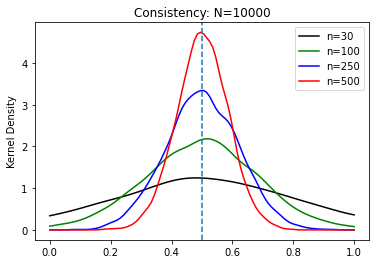

In [15]:
# OLS推定量のリスト
b1hat_list = [data_consistency['30'],data_consistency['100'],data_consistency['250'],data_consistency['500']]

# 色のリスト
color_list = ['k', 'g', 'b', 'r']

# ラベルのリスト
label_list = [30, 100, 250, 500]

#　横軸
xx=np.linspace(0.0,1.0,100)

#　下の説明（１）を参照 
for (b, c, l) in zip(b1hat_list, color_list, label_list):
    kde_model=gaussian_kde(b)
    plt.plot(xx, kde_model(xx), c, label='n={}'.format(l))  # 下の説明（２）

plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')
plt.title('Consistency: N={}'.format(N))  # 下の説明（２）
plt.legend()
pass

In [16]:
b0 = 1  # 定数項
b1 = 0.5  # 説明変数の係数

In [17]:
u_sd = 1

In [18]:
N = 100000

In [19]:
@njit  # 関数の高速化
def sim_norm(n):  # n=標本の大きさ
    
    q1_arr = np.zeros(N)  # q1を入れる空array
    
    x = np.random.normal(loc=4, scale=1, size=n)  # N回の推定に同じ説明変数を使う

    for j in range(N):  # N 回のループ
        
        u = np.random.normal(loc=0, scale=u_sd, size=n)  # 誤差項
        y = b0 + b1 * x + u  # 説明変数
        
        var_cov = np.cov(y,x)  # 分散共分散行列
        cov_yx = var_cov[0,1]  # 共分散
        var_y = var_cov[0,0]  # yの分散
        var_x = var_cov[1,1]  # xの分散        
        
        b1hat = cov_yx / var_x  # b1の推定値
        b0hat = np.mean(y)-b1hat*np.mean(x)  #b0の推定値
        yhat = b0hat + b1hat*x  # yの予測値
        uhat = y - yhat  # 残差
        
        rss = np.sum(uhat**2)  # 残差平方話
        sigma2 = rss/(n-2)  # 回帰の残差（不偏）分散 
        ser = np.sqrt(sigma2)  # 回帰の標準誤差
        
        b1se = ser/np.sqrt(n*np.var(x))  # b1の標準誤差
        
        q1 = (b1hat - b1)/b1se  # q1の値
    
        q1_arr[j] = q1  # t値をarrayに追加
    
    return q1_arr  # 返り値の設定

In [20]:
q1_norm = {}  # 空の辞書の作成

for i in [5,10,30,100]:
    q1_norm[str(i)] = sim_norm(i)

In [21]:
def plot_dist(n, q1_arr):  # n=標本の大きさ，q1_arr=q1値のarray
    
    xx=np.linspace(-3,3,num=100)  # 図を作成するために横軸の値を設定

    kde_model=gaussian_kde(q1_arr)  # カーネル密度推定を使いt値の分布を推定
    
    t_dist = t.pdf(xx,df=n-2)  # 同じ自由度のt分布
    
    plt.plot(xx, kde_model(xx), 'g-')  # t値の分布プロット
    plt.plot(xx, t_dist,'b:')  # t分布
    plt.ylabel('Kernel Density')  # 縦軸のラベル
    plt.title('n = {0}'.format(n))  # タイトル

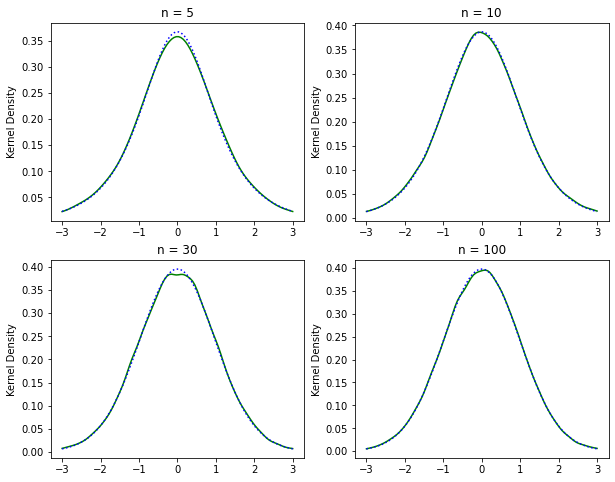

In [22]:
plt.figure(figsize=(10, 8))

# n = 5
plt.subplot(221)
plot_dist(5, q1_norm['5'])

# n = 10
plt.subplot(222)
plot_dist(10, q1_norm['10'])

# n = 30
plt.subplot(223)
plot_dist(30, q1_norm['30'])

# n = 100
plt.subplot(224)
plot_dist(100, q1_norm['100'])
pass

In [23]:
@njit  # 関数の高速化
def sim_non_norm(n):  # n=標本の大きさ
    
    q1_arr = np.zeros(N)  # q1を入れる空array
    
    x = np.random.normal(loc=4, scale=1, size=n)  # N回の推定に同じ説明変数を使う

    for j in range(N):  # N 回のループ
        
        ###### 非正規分布の誤差項（次の行だけが異なる）######
        u = (np.random.chisquare(1, size=n) - 1) / np.sqrt(2)
        
        y = b0 + b1 * x + u  # 説明変数
        
        var_cov = np.cov(y,x)  # 分散共分散行列
        cov_yx = var_cov[0,1]  # 共分散
        var_y = var_cov[0,0]  # yの分散
        var_x = var_cov[1,1]  # xの分散        
        
        b1hat = cov_yx / var_x  # b1の推定値
        b0hat = np.mean(y)-b1hat*np.mean(x)  #b0の推定値
        yhat = b0hat + b1hat*x  # yの予測値
        uhat = y - yhat  # 残差
        
        rss = np.sum(uhat**2)  # 残差平方話
        sigma2 = rss/(n-2)  # 回帰の残差（不偏）分散 
        ser = np.sqrt(sigma2)  # 回帰の標準誤差
        
        b1se = ser/np.sqrt(n*np.var(x))  # b1の標準誤差
        
        q1 = (b1hat - b1)/b1se  # q1の値
    
        q1_arr[j] = q1  # t値をarrayに追加
    
    return q1_arr  # 返り値の設定

In [24]:
q1_non_norm = {}  # 空の辞書の作成

for i in [5,10,30,100]:
    q1_non_norm[str(i)] = sim_non_norm(i)

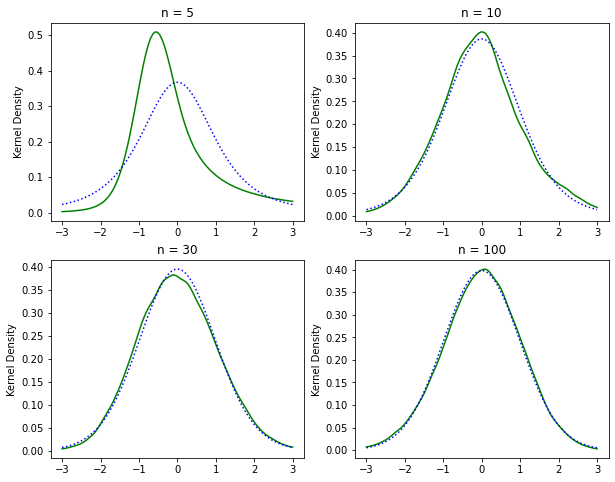

In [25]:
plt.figure(figsize=(10, 8))

# n = 5
plt.subplot(221)
plot_dist(5, q1_non_norm['5'])

# n = 10
plt.subplot(222)
plot_dist(10, q1_non_norm['10'])

# n = 30
plt.subplot(223)
plot_dist(30, q1_non_norm['30'])

# n = 100
plt.subplot(224)
plot_dist(100, q1_non_norm['100'])
pass

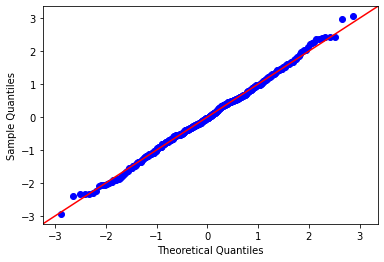

In [26]:
data_norm = norm.rvs(scale=5, size=500)
qqplot(data_norm, line='45', fit=True)
pass

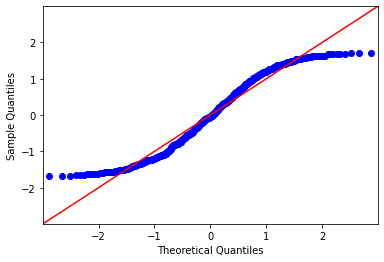

In [27]:
data_uniform = uniform.rvs(size=500)
qqplot(data_uniform, line='45', fit=True)
pass

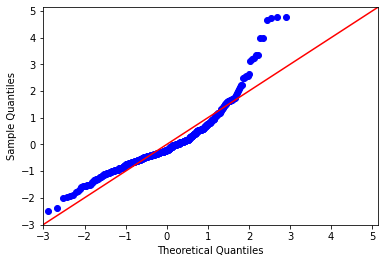

In [28]:
wage1 = wooldridge.data('wage1')
formula_wage = 'wage ~ educ + exper+ tenure'
res_wage = ols(formula_wage, data=wage1).fit()
qqplot(res_wage.resid, line='45',fit=True)
pass

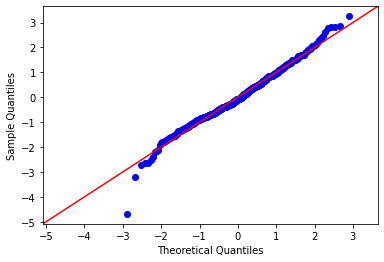

In [29]:
wage1 = wooldridge.data('wage1')
formula_wage_log = 'np.log(wage) ~ educ + exper+ tenure'
res_wage_log = ols(formula_wage_log, data=wage1).fit()
qqplot(res_wage_log.resid, line='45',fit=True)
pass

In [30]:
jarque_bera(data_norm)

(0.2397632828693799,
 0.8870254175601601,
 0.05329934346615883,
 3.0120564307336775)

In [31]:
jarque_bera(data_uniform)

(31.849341384445342,
 1.213398328190267e-07,
 0.03651996101953241,
 1.7657254939674465)

In [32]:
jarque_bera(res_wage.resid)

(650.807511291524,
 4.774682881101464e-142,
 1.5548017153087925,
 7.474930815416471)

In [33]:
jarque_bera(res_wage_log.resid)

(20.94123198237358,
 2.8357585677393478e-05,
 0.02123204915915199,
 3.9765706706813067)

In [34]:
print(res_wage_log.summary().tables[2])

Omnibus:                       11.534   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.941
Skew:                           0.021   Prob(JB):                     2.84e-05
Kurtosis:                       3.977   Cond. No.                         135.


In [35]:
omni_normtest(data_norm)

NormaltestResult(statistic=0.28930194294935024, pvalue=0.8653242632611116)

In [36]:
omni_normtest(data_uniform)

NormaltestResult(statistic=409.9776848236365, pvalue=9.429244319515016e-90)

In [37]:
omni_normtest(res_wage.resid)

NormaltestResult(statistic=179.5971758439393, pvalue=1.0022331946711146e-39)

In [38]:
omni_normtest(res_wage_log.resid)

NormaltestResult(statistic=11.534386892183383, pvalue=0.003128525580078861)

In [39]:
print(res_wage_log.summary().tables[2])

Omnibus:                       11.534   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.941
Skew:                           0.021   Prob(JB):                     2.84e-05
Kurtosis:                       3.977   Cond. No.                         135.


In [40]:
crime1 = wooldridge.data('crime1')
wooldridge.data('crime1', description=True)

name of dataset: crime1
no of variables: 16
no of observations: 2725

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| narr86   | # times arrested, 1986          |
| nfarr86  | # felony arrests, 1986          |
| nparr86  | # property crme arr., 1986      |
| pcnv     | proportion of prior convictions |
| avgsen   | avg sentence length, mos.       |
| tottime  | time in prison since 18 (mos.)  |
| ptime86  | mos. in prison during 1986      |
| qemp86   | # quarters employed, 1986       |
| inc86    | legal income, 1986, $100s       |
| durat    | recent unemp duration           |
| black    | =1 if black                     |
| hispan   | =1 if Hispanic                  |
| born60   | =1 if born in 1960              |
| pcnvsq   | pcnv^2                          |
| pt86sq   | ptime86^2                       |
| inc86sq  | inc86^2                         |
+----------+-------------------------

In [41]:
form_0 = 'narr86 ~ pcnv + ptime86 + qemp86 + avgsen + tottime'
res_0 = ols(form_0, data=crime1).fit()
res_0.params

Intercept    0.706061
pcnv        -0.151225
ptime86     -0.039259
qemp86      -0.103091
avgsen      -0.007049
tottime      0.012095
dtype: float64

In [42]:
form_1 = 'narr86 ~ pcnv + ptime86 + qemp86'
res_1 = ols(form_1, data=crime1).fit()
res_1.params

Intercept    0.711772
pcnv        -0.149927
ptime86     -0.034420
qemp86      -0.104113
dtype: float64

In [43]:
res_0.compare_lm_test(res_1)

(4.070729461071163, 0.13063282803270007, 2.0)